## **Göğüs X-Ray Taramalarından Hastalık Teşhisi**

DenseNet ve ChestX-ray8 veriseti kullanılarak göğüs X-Ray taramalarından göğüs hastalıklarının teşhisinin yapılmasını amaçlayan bir çalışmadır. Veriseti eklenmemiştir. 

Verisetine bağlantıdan ulaşabilirsiniz. https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/37178474737 

DenseNet Modeline bağlantıdan erişebilirsiniz : https://www.kaggle.com/pytorch/densenet121

PS. Bu çalışma Coursera'da Deeplearning.ai tarafından yayınlanan Medikal Teşhiste Yapay Zeka dersinden örnek alınmıştır.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!ls '/content/gdrive/My Drive/data_chest'
root='/content/gdrive/My Drive/'

chest_notebook.ipynb  images-small	   test.csv	    util.py
densenet.hdf5	      pretrained_model.h5  train-small.csv  valid-small.csv


## **Kütüphaneler**

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

import util


## **Veri Seti Entegrasyonu**

In [0]:
train_df = pd.read_csv(root+"data_chest/train-small.csv")
valid_df = pd.read_csv(root+"data_chest/valid-small.csv")

test_df = pd.read_csv(root+"data_chest/test.csv")

## **Veri Setinde Tanımlı Hastalıkların Etiketleri**

In [0]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

## **Ağırlıkların Kaybı**
Ağırlıkların kaybını hesaplayan bir kayıp fonksiyonu döndürürüyoruz. loss = 0.0 olmasının sebebi öngörülen değer sıfır olduğunda ortaya çıkabilecek sayısal bir hatayı önlemek içindir.

In [0]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):

    def weighted_loss(y_true, y_pred):

        loss = 0.0
        for i in range(len(pos_weights)):
           
            loss += -(K.mean( pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + epsilon) + \
                                neg_weights[i] * (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + epsilon), axis = 0))
        return loss
    return weighted_loss

## **Veri Sızıntısının Önlenmesi**
Benzersiz hasta kimlik numaraları toplam kayit sayisindan fazla ise burada bir cakışma söz konusudur. Birden fazla kaydı olan hastalar için, veri sızıntısını önlemek amacıyla hem eğitim hem de test setlerinde görünmediğinden emin olmalısınız. 

In [0]:
def check_for_leakage(df1, df2, patient_col):

    df1_patients_unique = set(df1[patient_col].unique().tolist())
    df2_patients_unique = set(df2[patient_col].unique().tolist())

    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    leakage = len(patient_col)>0
    
    return leakage

In [9]:
print("Egitim ve Test seti arasindaki sizinti: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("Dogrulama ve Test seti arasindaki sizinti: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

Egitim ve Test seti arasindaki sizinti: True
Dogrulama ve Test seti arasindaki sizinti: True


##**ImageDataGenerator**
Eğitimden önce, resimleri evrişimli bir sinir ağı eğitimi için daha uygun olacak şekilde değiştirmemiz gerekmekte. Bunun icin Derin Öğrenme Kütühanesi olan Keras icindeki ImageDataGenerator fonksiyonunu kullanacagiz. 

In [0]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    print("getting train generator...") 

    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)

    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [0]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):

    print("getting train and valid generators...")
    # Örnek veri kümesini için ImageDataGenerator()
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # Veri örneği alıyoruz
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # Test seti üreticisi için ortalama ve standart sapmanın uyacak şekilde kullanımı
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # Üreticinin eğitim verilerinden örneklere uygun hale getirilmesi
    image_generator.fit(data_sample)

    # Test Üreticisi
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

## **X-Ray Görüntülerinin Dizini**



In [12]:
IMAGE_DIR = root+"data_chest/images-small/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


## **Sınıfların Frekanslarının Hesaplanması**

Sınıf dengesizliğini etkilemekten kaçınmanın bir yolu kayıp fonksiyonunu farklı şekilde ağırlıklandırmaktır. Ağırlıkları seçmek için önce sınıf frekanslarını hesaplamanız gerekir.

In [0]:
def compute_class_freqs(labels):

    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0) / labels.shape[0]
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

## **Eğitim verilerimiz için frekansları hesaplıyoruz.**

In [0]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)

Pozitif ve negatif etiketlerin katkısını dengeliyoruz.

In [0]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

## **DenseNet ve Eğitilmiş Modelin Entegrasyonu**

In [0]:
base_model = DenseNet121(weights=root+'/data_chest/densenet.hdf5', include_top=False)

x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

## **Eğitim**

Bu çalışmada önceden eğitilmiş bir modeli kullandık eğitim için aşağıdaki kod blogunu çalıştırabilirsiniz. 

In [17]:
'''
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 3)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()
'''

'\nhistory = model.fit_generator(train_generator, \n                              validation_data=valid_generator,\n                              steps_per_epoch=100, \n                              validation_steps=25, \n                              epochs = 3)\n\nplt.plot(history.history[\'loss\'])\nplt.ylabel("loss")\nplt.xlabel("epoch")\nplt.title("Training Loss Curve")\nplt.show()\n'

## **Eğitilmiş Modelin Yüklenmesi**

In [0]:
model.load_weights(root+"/data_chest/pretrained_model.h5")

## **Tahmin ve Değerlendirme**

In [0]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

## **ROC Eğrisi ve AUC (Eğri Altında Kalan Alan) Grafiği**

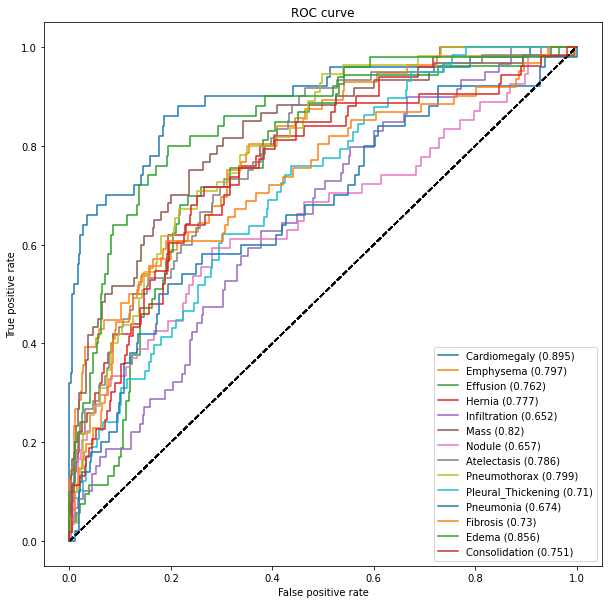

In [20]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

In [0]:
df = pd.read_csv(root+"data_chest/train-small.csv")
IMAGE_DIR = root+"data_chest/images-small/"

labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

## **GradCAM ile Öğrenmeyi Görselleştirme**

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


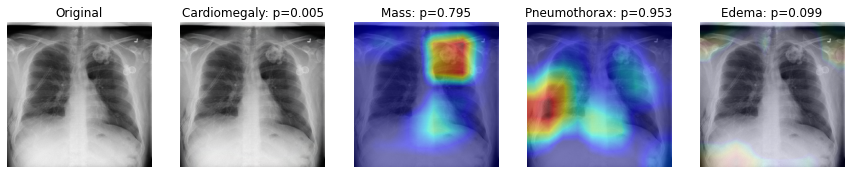

In [22]:
util.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)